In [1]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import auxiliar as aux
from preprocessing import apply_ODE, init_dataset, discretize_columns, reduce_by_frequency

# **Categorical Naive Bayes**

Los hiperparámetros que consideramos relevantes para el modelo CategoricalNB son:
   - alpha: Parámetro de suavisado (Laplace/Lidstone) para evitar probabilidad 0 en aquellas categorias que nunca aparecen

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se optó unicamente tratar los missings como categóricos:

In [2]:
X,y = aux.get_train_set()
X = init_dataset(X)

### Preprocesamiento 1: ODE

Para aplicar este tipo de modelo debemos quedarnos solo con columnas categóricas para luego aplicar Ordinal Encoder (ODE). Primero vamos a ver como funciona el modelo eliminando las columnas numéricas del dataset original.

In [3]:
X_category = X.select_dtypes(include=['category'])
X_category.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado


Luego aplicamos ODE a las columnas como se mencionó anteriormente debido a que CategoricalNB funciona unicamente con valores categoricos:

In [4]:
X_ode = apply_ODE(X_category)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ode, y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo categoricalNB con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [6]:
parameters = {
    'alpha': np.arange(0, 1, 0.01),
}

clf = CategoricalNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8497994658915576
Mejores Parametros {'alpha': 0.74}

Mejor score ROC-AUC en Validación: 0.8408609500423021


Armamos el modelo de CategoricalNB con los hiperparámetros calculados:

In [7]:
model_categoricalNB = gscv.best_estimator_
model_categoricalNB

CategoricalNB(alpha=0.74)

Predecimos con el validation set:

In [8]:
categoricalNB_predict = model_categoricalNB.predict(X_validation)

**Metricas**

In [9]:
print(classification_report(y_validation, categoricalNB_predict))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      4945
           1       0.49      0.76      0.60      1568

    accuracy                           0.75      6513
   macro avg       0.70      0.75      0.71      6513
weighted avg       0.81      0.75      0.77      6513



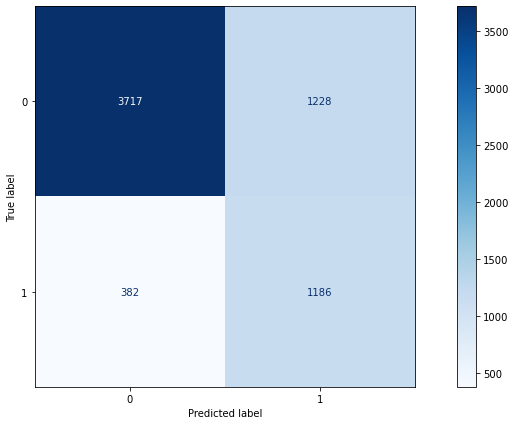

In [10]:
aux.plot_cm(model_categoricalNB, X_validation, y_validation)

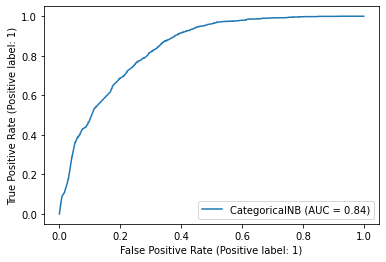

In [11]:
plot_roc_curve(model_categoricalNB, X_validation, y_validation, response_method="predict_proba")
plt.show()

Vemos que este modelo es uno de los que mejor *recall* tiene sobre la clase 1 de nuestra variable objetivo. 

### Preprocesamiento 2: Reduccion por frecuencia + ODE

Ahora vemos que sucede si reduciremos por frecuencia de aparicion algunas columnas y luego aplicaremos ODE a las columnas categoricas. Reduciremos mediante la funcion **reduce_by_frequency_occurrence** que por predeterminado tiene las columnas *Barrio, Religion, Categoria de Trabajo, Estado Marital*:

In [12]:
columns = ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital']
X_p2 = reduce_by_frequency(X_category, columns, 0.15)
X_p2.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,palermo,otros,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,palermo,otros,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente
2,palermo,relacion_de_dependencia,otros,hombre,cristianismo,sin_familia,limpiador
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,otros,casado,limpiador
4,otros,relacion_de_dependencia,matrimonio_civil,mujer,otros,casada,profesional_especializado


Luego debemos aplicar ODE como hizimos en el preprocesado anterior:

In [13]:
X_ode_p2 = apply_ODE(X_p2)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ode_p2,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo categoricalNB con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [15]:
parameters = {
    'alpha': np.arange(0, 1, 0.01),
}

clf = CategoricalNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8471068940906367
Mejores Parametros {'alpha': 0.2}

Mejor score ROC-AUC en Validación: 0.8388703674088442


Armamos el modelo de CategoricalNB con los hiperparametros calculados:

In [16]:
model_categoricalNB_p2 = gscv.best_estimator_
model_categoricalNB_p2

CategoricalNB(alpha=0.2)

Predecimos con el validation set:

In [17]:
categoricalNB_predict = model_categoricalNB_p2.predict(X_validation)

**Metricas**

In [18]:
print(classification_report(y_validation, categoricalNB_predict))

              precision    recall  f1-score   support

           0       0.91      0.74      0.81      4945
           1       0.48      0.77      0.59      1568

    accuracy                           0.74      6513
   macro avg       0.69      0.75      0.70      6513
weighted avg       0.81      0.74      0.76      6513



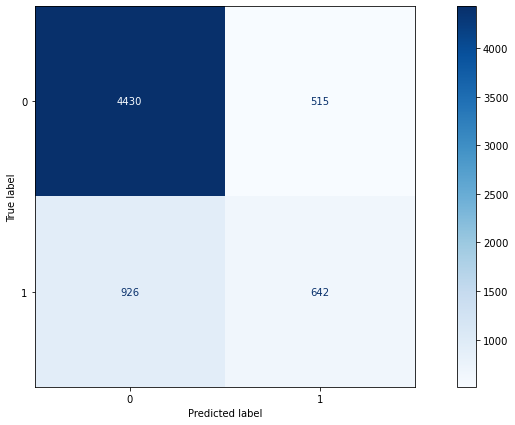

In [19]:
aux.plot_cm(model_categoricalNB, X_validation, y_validation)

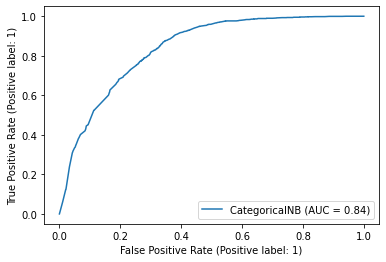

In [20]:
plot_roc_curve(model_categoricalNB_p2, X_validation, y_validation, response_method="predict_proba")
plt.show()

### Preprocesamiento 3: Discretizacion de columnas + ODE

Ahora veremos que sucede si en vez de quedarnos solo con las columnas categoricas, discretizamos las columnas numéricas y luego aplicaremos ODE. Al realizar esta primera discretizacion de columnas tendremos todo el dataset con columnas cateogricas. Discretizaremos mediante la funcion **discretize_columns** que por predeterminado tiene las columnas *Años Estudiados, Edad, Horas de Trabajo, Ganancia/Perdida Bolsa Argentina*:

In [21]:
X_p3 = discretize_columns(X)
X_p3.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo,anios_estudiados_bins,edad_bins,horas_trabajo_registradas_bins,ganancia_perdida_declarada_bolsa_argentina_bins
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento,4,1,1,0
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente,4,2,0,0
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador,3,1,1,0
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador,2,3,1,0
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado,4,0,1,0


Luego debemos aplicar ODE como en los anteriores casos:

In [22]:
X_ode_p3 = apply_ODE(X_p3)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [23]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ode_p3,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparámetros para el modelo categoricalNB con GridSearchCV. La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [24]:
parameters = {
    'alpha': np.arange(0, 1, 0.01),
}

clf = CategoricalNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8934156599185314
Mejores Parametros {'alpha': 0.1}

Mejor score ROC-AUC en Validación: 0.8849950862549266


Armamos el modelo de CategoricalNB con los hiperparámetros calculados:

In [25]:
model_categoricalNB_p3 = gscv.best_estimator_
model_categoricalNB_p3

CategoricalNB(alpha=0.1)

Predecimos con el validation set:

In [26]:
categoricalNB_predict = model_categoricalNB_p3.predict(X_validation)

**Metricas**

In [27]:
print(classification_report(y_validation, categoricalNB_predict))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4945
           1       0.56      0.77      0.65      1568

    accuracy                           0.80      6513
   macro avg       0.74      0.79      0.76      6513
weighted avg       0.83      0.80      0.81      6513



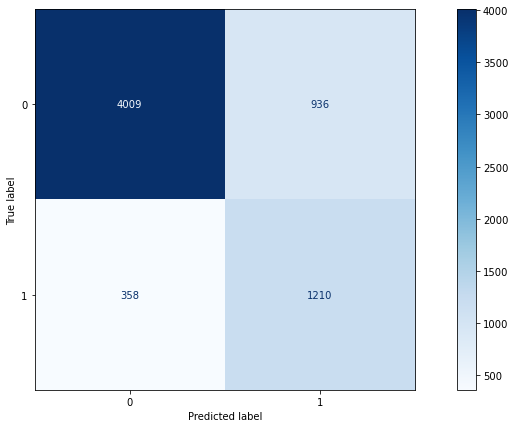

In [28]:
aux.plot_cm(model_categoricalNB_p3, X_validation, y_validation)

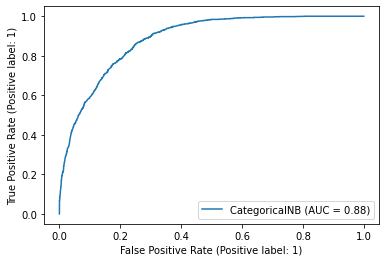

In [29]:
plot_roc_curve(model_categoricalNB_p3, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que utilizando CategoricalNB tenemos una mal performance de la metrica *auc_roc* en comparación con los demas modelos. Ademas observamos que es uno de los modelos con mejor metrica *recall* sobre la clase 1 de nuestra variable objetivo. Aplicando una reducción de las columnas cateogricas nos aporto una mejora pero no tan relevante. Luego vimos que discretizando las columnas numéricas, convirtiendolas en cateogricas, obtenemos una ganancia en la metrica *auc_roc* debido a que contamos con mas informacion que sin haber aplicado este preproceso.

# Predicción

Por ultimo, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [30]:
ids, X_holdout = aux.get_holdout_set()
X_holdout = init_dataset(X_holdout)

In [31]:
X_holdout_p3 = discretize_columns(X_holdout)
X_holdout_ode = apply_ODE(X_holdout_p3)

In [32]:
categoricalNB_predict = model_categoricalNB_p3.predict(X_holdout_ode)

In [33]:
aux.create_prediction(ids, categoricalNB_predict, file_name='categoricalNB')